In [21]:
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
# Date time conversion registration
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale = 1.6, style="white")

In [24]:
df = pd.read_csv('d:/Datasets//t0_predict_data.csv')
df['trade_time'] = pd.to_datetime(df['trade_time'])

#考虑到需要预测的是业务日各渠道的总量，所以按照业务日定义将交易时间倒推9.5小时，并提取日期，以便聚合数据
df['trade_date'] = (df['trade_time'] - datetime.timedelta(hours = 9.5)).dt.date
df['trade_date'] = df['trade_date'].astype(str)
df.head()

,trade_time,channel,sale_value,trade_date
0,2018-01-01 00:00:00,J,19294.696110,2017-12-31
1,2018-01-01 00:00:00,U,3505.435170,2017-12-31
2,2018-01-01 00:10:00,G,16.773906,2017-12-31
3,2018-01-01 00:15:00,G,-5.820908,2017-12-31
4,2018-01-01 00:15:00,H,896.415721,2017-12-31


In [29]:
#数据的起始点为2018年1月1日，预测的业务日为2019年2月22日各渠道的业务总量，
#因此，可供对比的日期段仅为[2018-01-01 00:00:00, 2018-02-22 13:55:00] with [2019-01-01 00:00:00, 2019-02-22 13:55:00】
#时间段较短，数据维度低，且预测的仅为后一日的交易总量，因此不适合常规的机器学习算法（容易过拟合），且不适合过度利用数据的周期性
#先对同比时间段内各渠道的业务量相关性进行探索性分析
con_dates = [datetime.date(2018,1,1), datetime.date(2018,3,6)] 
con_df = df[(df['trade_date'] >= con_dates[0]) & (df['trade_date'] <= con_dates[1])]

exp_dates = [datetime.date(2019,1,1), datetime.date(2019,2,28)] 
exp_df = df[(df['trade_date'] >= exp_dates[0]) & (df['trade_date'] <= exp_dates[1])]

sub_df = pd.concat([con_df, exp_df], axis = 0)

#按业务日和渠道聚合交易量数据
sub_df = sub_df.groupby(['trade_date', 'channel'])['sale_value'].agg('sum').reset_index()

In [59]:
def date_pattern_compare(agg_df, channel):
    _df = agg_df[agg_df['channel'] == channel]
    _df.loc[:, 'trade_date'] = pd.to_datetime(_df['trade_date'])
    _df.loc[:,'year'] = _df['trade_date'].dt.year
    _df.loc[:,'x_axis'] = _df['trade_date']
    _df.loc[_df['x_axis'] >= pd.to_datetime('2019-01-01'), 'x_axis'] -= datetime.timedelta(days = 365)
    return _df

def plot_channel_df(channel_df, days_shift = 0):
    _df = channel_df.copy()
    if days_shift != 0:
        _df.loc[_df['year'] == 2019, 'x_axis'] += datetime.timedelta(days = days_shift)
    
    f, ax = plt.subplots(figsize = (16, 6))
    sns.lineplot(x = 'x_axis', y = "sale_value", hue = 'year', data = _df)
    ax.set(xlabel = 'Dates')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d"))
    return None

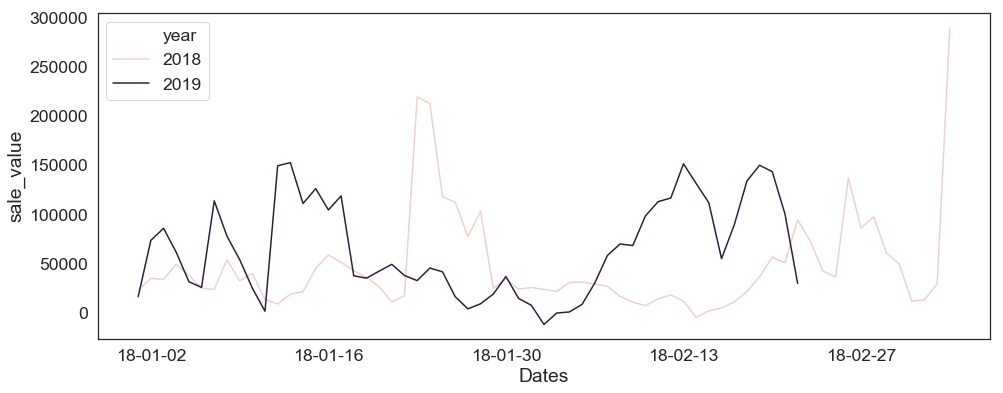

In [60]:
A_df = date_pattern_compare(sub_df, channel = 'A')
plot_channel_df(A_df)

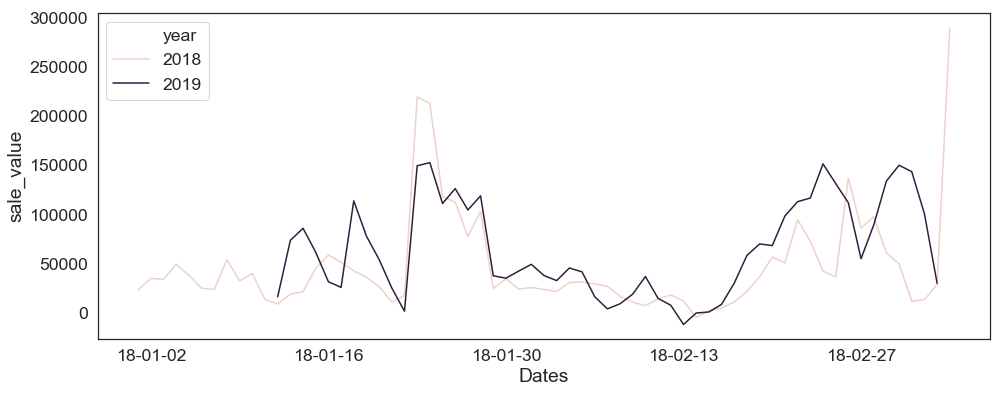

In [61]:
#从channel A两年的交易量可以看到明显的时间规律，由于2018年春节是2月16日，2019年春节是2月5日，相差11天
#将channel A中2019年的数据向后平移11天，并可视化
plot_channel_df(A_df, days_shift = 11)

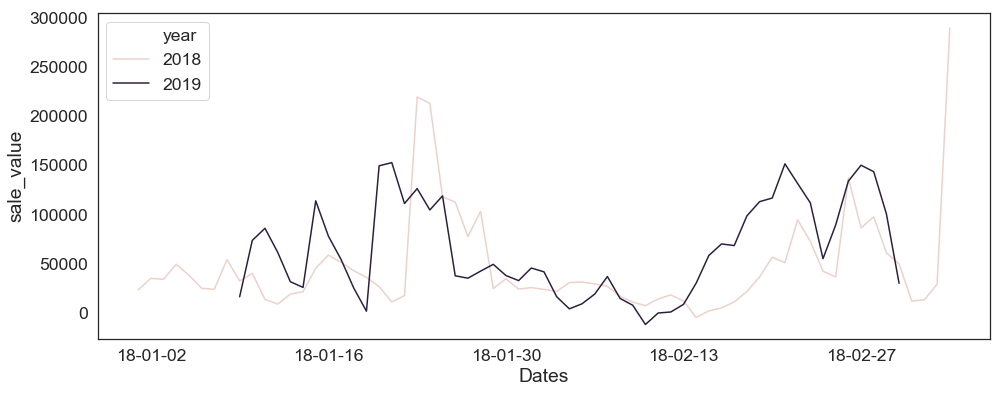

In [62]:
#从上图可以看到，平移后的数据规律更加显著，两年正月初一当天都发生了交易量的大幅增加，但在临近时间段存在一定的偏移
#可能的远因是，2018年春节后11天已接近3月8日
#考虑到需要预测的业务日为2019年2月22日，更应该保持临近时间段数据规律的一致性，因此考虑将2019年的数据再向前平移
plot_channel_df(A_df, days_shift = 8)

In [ ]:
#从上图可以看出，平移后channel A在近期的峰值规律与去年较一致，且2019年channel A在2019年2月22日近期的交易量较去年同期略高

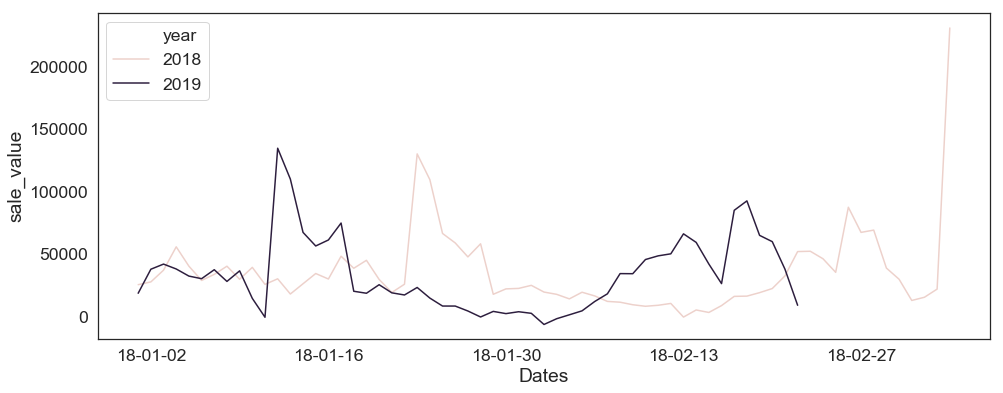

In [63]:
#同理，对其他渠道进行探索性分析
#channel E
E_df = date_pattern_compare(sub_df, channel = 'E')
plot_channel_df(E_df, days_shift=0)

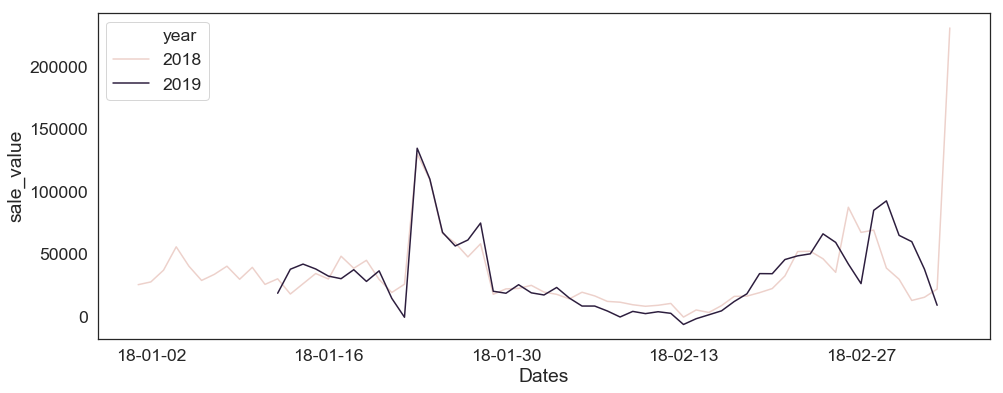

In [64]:
#同样，经过春节日期差平移后的数据在近期端偏快，需要往回平移
plot_channel_df(E_df, days_shift = 11)

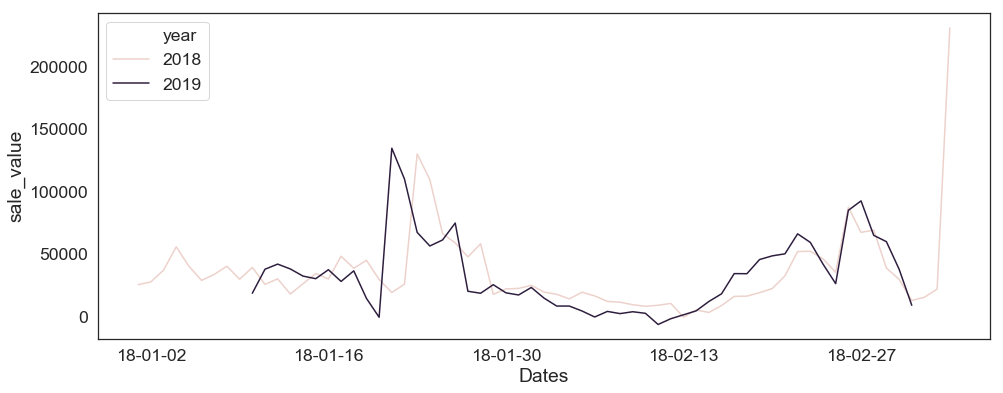

In [65]:
#和channel A不同，channel E往回平移2天最佳
plot_channel_df(E_df, days_shift = 9)

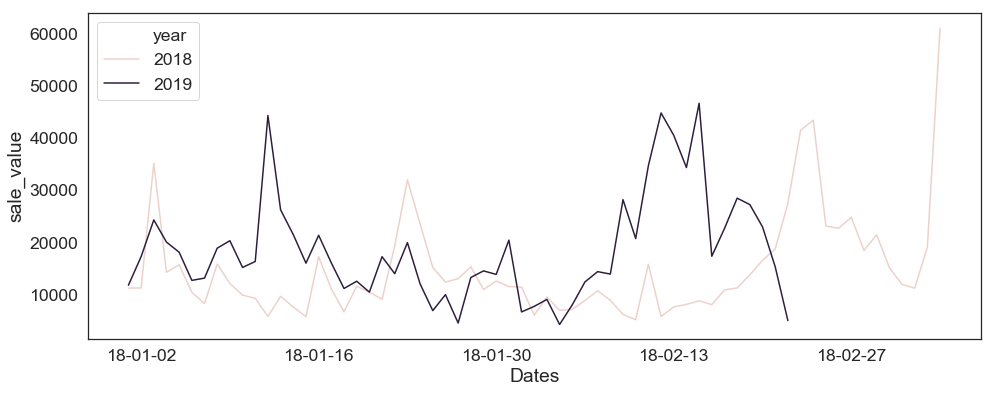

In [66]:
#channel G
G_df = date_pattern_compare(sub_df, channel = 'G')
plot_channel_df(G_df, days_shift = 0)

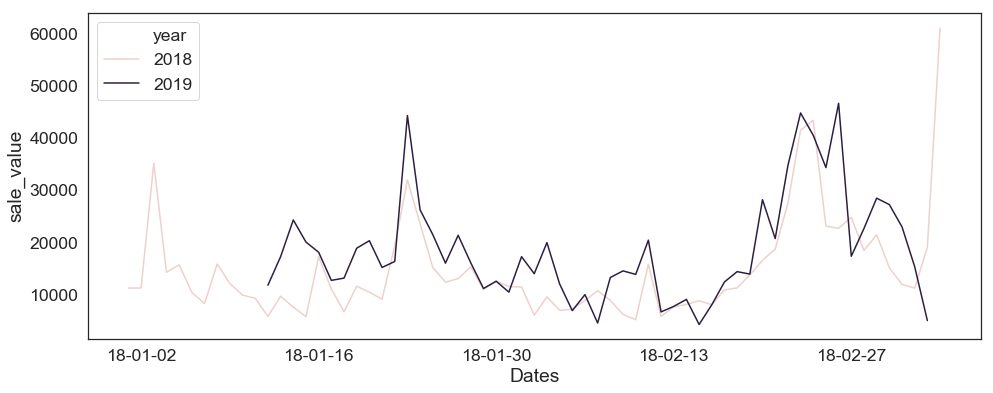

In [67]:
plot_channel_df(G_df, days_shift = 11)

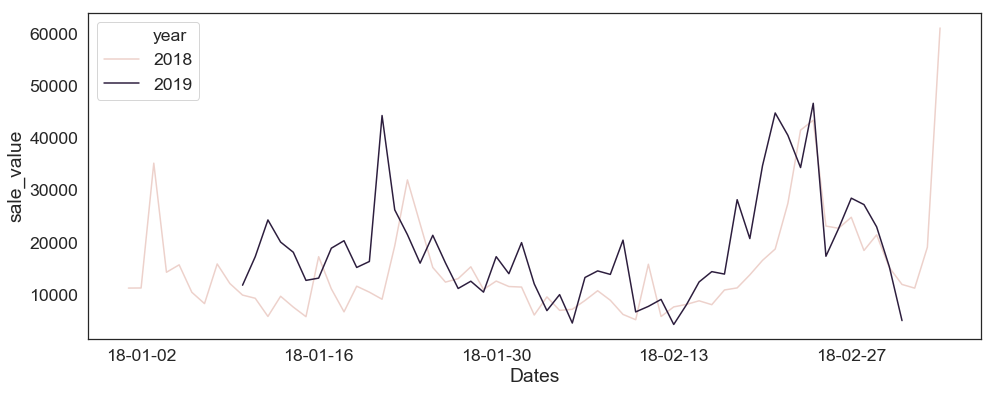

In [68]:
#channel G具有和channel E相似的数据pattern
plot_channel_df(G_df, days_shift = 9)

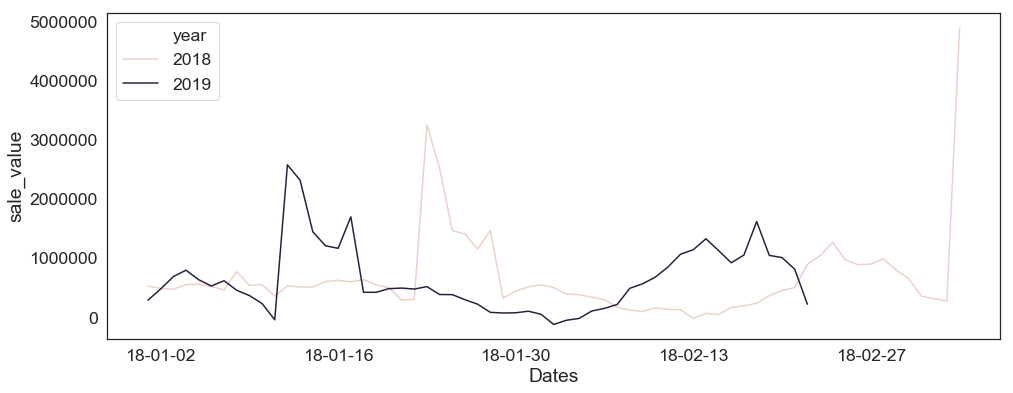

In [69]:
#channel H
H_df = date_pattern_compare(sub_df, channel = 'H')
plot_channel_df(H_df, days_shift = 0)

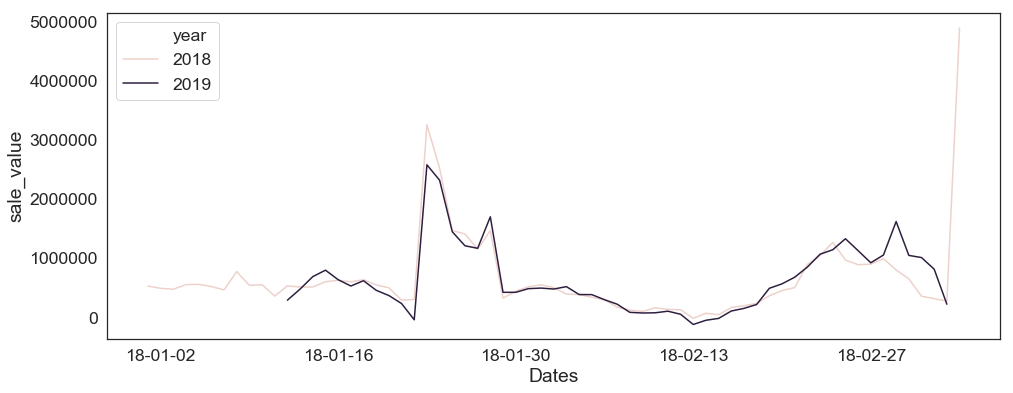

In [70]:
plot_channel_df(H_df, days_shift = 11)

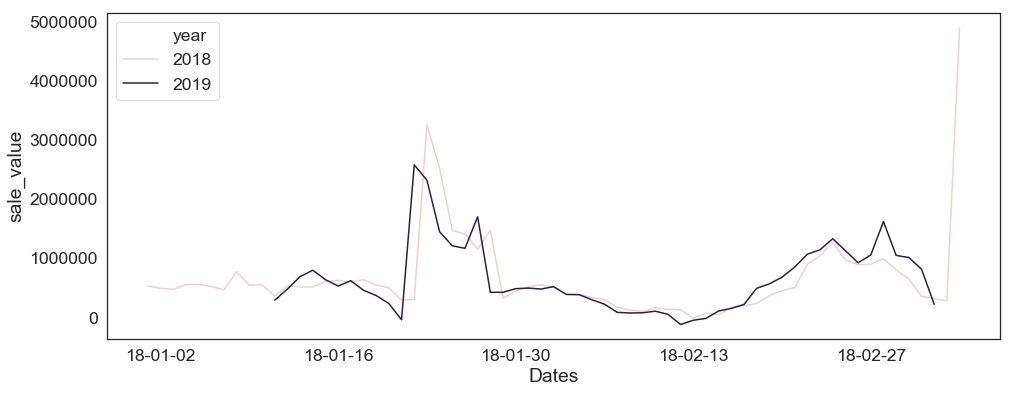

In [71]:
#channel H平移1天尤佳
plot_channel_df(H_df, days_shift = 10)

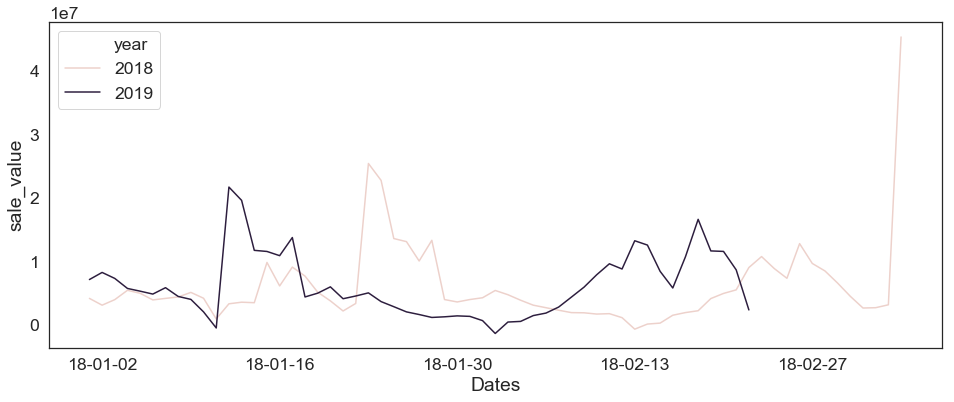

In [72]:
#channel J
J_df = date_pattern_compare(sub_df, channel = 'J')
plot_channel_df(J_df, days_shift = 0)

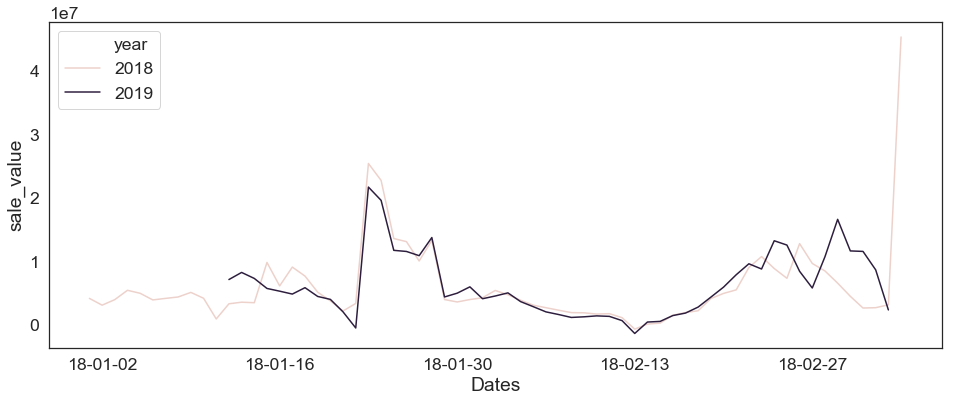

In [73]:
plot_channel_df(J_df, days_shift = 11)

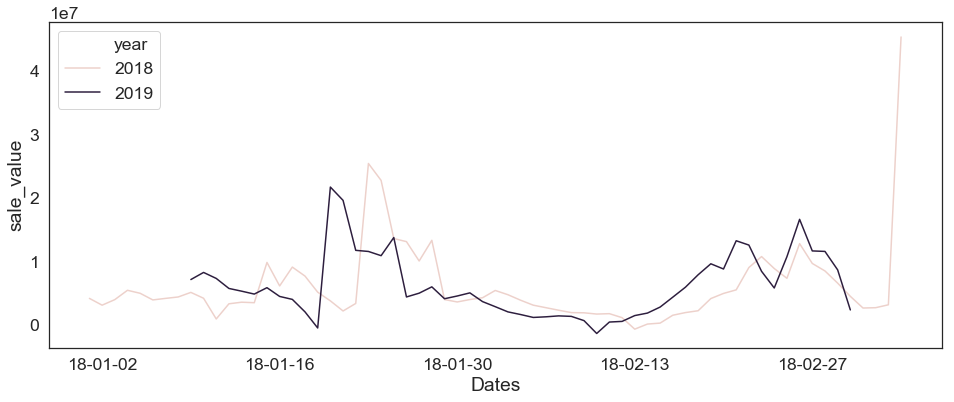

In [74]:
plot_channel_df(J_df, days_shift = 8)

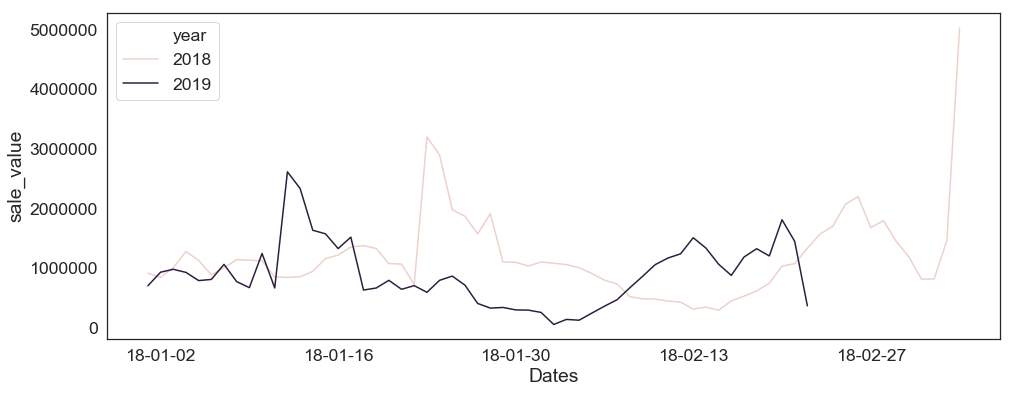

In [75]:
#channel U
U_df = date_pattern_compare(sub_df, channel = 'U')
plot_channel_df(U_df, days_shift = 0)

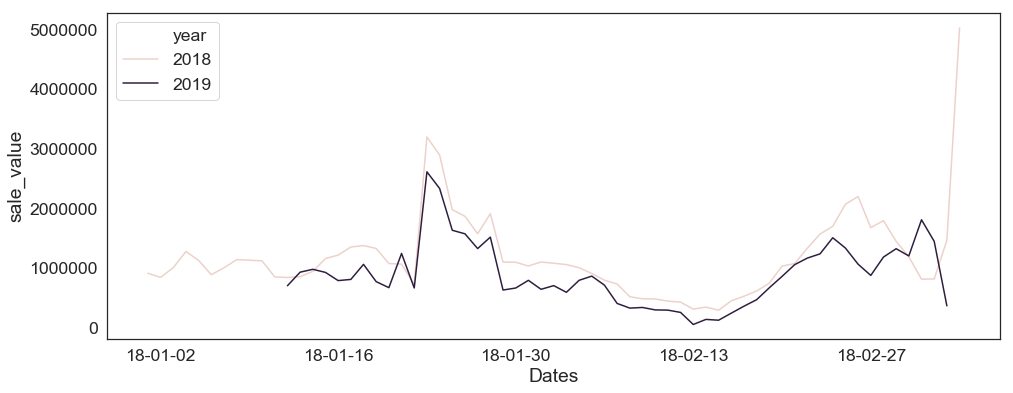

In [76]:
plot_channel_df(U_df, days_shift = 11)

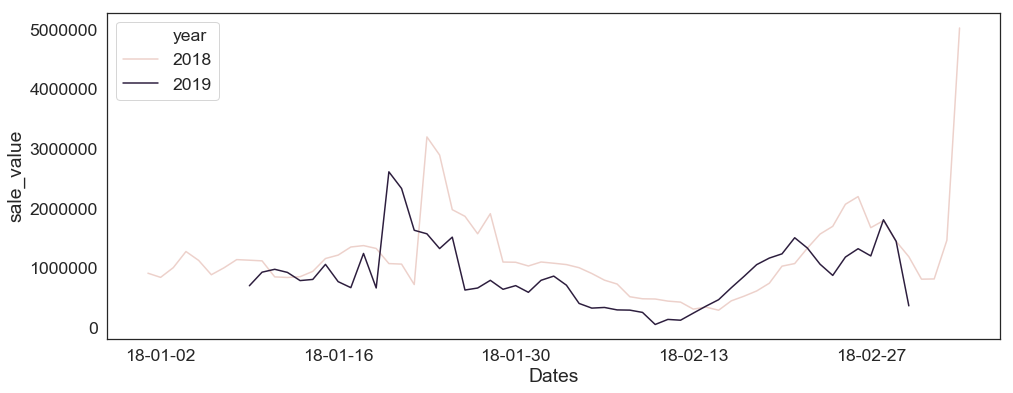

In [77]:
plot_channel_df(U_df, days_shift = 8)

In [ ]:
#由于数据量的限制以及同期数据之间交强的相关性特征，考虑采用移动平均的方式计算预测业务日的交易总量，并通过和同期数据在近期业务日不同渠道业务总量的对比进行小幅度修正

In [333]:
def shift_mean_pred(full_df, biz_date, days_shift):   
    #提取要预测的日期当天09:30:00-13:55:00的数据
    date_pred = pd.to_datetime(biz_date + ' 09:30:00')
    time_end = pd.to_datetime(biz_date + ' 13:55:00')
    
    pred_df = full_df[(full_df['trade_time'] >= date_pred) & (full_df['trade_time'] <= time_end)]
    pred_df = pd.DataFrame(pred_df.groupby('channel')['sale_value'].agg('sum')).reset_index()   
    
    #用预测日期之前days_shift天的数据做样本
    _full_df = full_df[full_df['trade_time'] < date_pred]
    _date_s = date_pred - datetime.timedelta(days = days_shift)
    _sale_sub = _full_df.loc[(_full_df['trade_time'] >= _date_s) & (_full_df['hour'] <= 13), :]
    _sale_full = _full_df.loc[(_full_df['trade_time'] >= _date_s)]
    
    _sale_sub_agg = pd.DataFrame(_sale_sub.groupby(['channel', 'trade_date'])['sale_value'].agg('sum')).reset_index()
    _sale_full_agg = pd.DataFrame(_sale_full.groupby(['channel', 'trade_date'])['sale_value'].agg('sum')).reset_index()
    
    merge_df = _sale_full_agg.merge(_sale_sub_agg, on = ['channel', 'trade_date'], how = 'inner')
    merge_df['period_percent'] = merge_df['sale_value_y']/merge_df['sale_value_x']
    
    coef_df = pd.DataFrame(merge_df.groupby('channel')['period_percent'].agg('mean')).reset_index()
    pred_df = pred_df.merge(coef_df, on = 'channel', how = 'inner')
    pred_df.loc[:,'pred'] = pred_df['sale_value']/pred_df['period_percent']
    return pred_df.loc[:, ['channel', 'pred']]

def channel_shift_pred(full_df, biz_date, channel_shift_days, use_his_days = 3):
    #利用数据分析得到的各渠道与去年同期时间段相比的数据规律对今年业务日各渠道总量进行预测
    #用滑动的去年同期预测日最近三天各渠道业务总量的均值和今年预测日近三天的均值做对比
    
    #获取预测时间
    date_pred = pd.to_datetime(biz_date + ' 09:30:00')
    
    #定义同期日期，根据不同渠道的数据规律滑动不同的天数
    con_date = date_pred - datetime.timedelta(days = 365)
    his_df = pd.DataFrame()
    con_df = pd.DataFrame()
    for channel, days_shift in channel_shift_days.items():
        channel_date_e = con_date + datetime.timedelta(days = days_shift)
        channel_date_e1 = channel_date_e + datetime.timedelta(days = 1)
        channel_date_s = channel_date_e - datetime.timedelta(days = use_his_days)
        _sub_df = full_df.loc[(full_df['trade_time'] >= channel_date_s) & (full_df['trade_time'] < channel_date_e) & (full_df['channel'] == channel),:]
        his_df = his_df.append(_sub_df)

        _sub_df = full_df.loc[(full_df['trade_time'] >= channel_date_e) & (full_df['trade_time'] < channel_date_e1) & (full_df['channel'] == channel),:]
        con_df = con_df.append(_sub_df)

    his_agg = pd.DataFrame(his_df.groupby(['channel', 'trade_date'])['sale_value'].agg('sum')).reset_index()
    his_agg = pd.DataFrame(his_agg.groupby(['channel'])['sale_value'].agg('mean')).reset_index()

    con_agg = pd.DataFrame(con_df.groupby(['channel'])['sale_value'].agg('sum')).reset_index()

    his_coef = his_agg.merge(con_agg, on = 'channel', how = 'inner')
    #求得历史同期各渠道最近三天的业务总量和预测日对应历史业务日的系数
    his_coef.loc[:, 'coef'] = his_coef['sale_value_x']/his_coef['sale_value_y']

    #计算当年最近三天各渠道的平均值
    date_s = date_pred - datetime.timedelta(days = use_his_days)
    exp_df = full_df.loc[(full_df['trade_time'] >= date_s) & (full_df['trade_time'] < date_pred)]
    exp_agg = pd.DataFrame(exp_df.groupby(['channel', 'trade_date'])['sale_value'].agg('sum')).reset_index()
    exp_agg = pd.DataFrame(exp_agg.groupby(['channel'])['sale_value'].agg('mean')).reset_index()

    combine_df = exp_agg.merge(his_coef, on = 'channel', how = 'inner')
    combine_df['pred'] = combine_df['sale_value']/combine_df['coef']
    return combine_df.loc[:, ['channel', 'pred']]

def train_process(full_df, biz_date, channel_shift_days, train_days):

    biz_df = full_df[full_df['trade_date'] == biz_date]
    biz_df = pd.DataFrame(biz_df.groupby('channel')['sale_value'].agg('sum')).reset_index()
    true_df = biz_df.loc[:, ['channel', 'sale_value']]
    true_df = true_df.rename(columns = {'sale_value': 'true'})
    
    channel_shift_eval = {}
    shift_mean_eval = {}

    for i in train_days:
        days_shift = i
        shift_pred_df = shift_mean_pred(full_df, biz_date, days_shift)
        shift_pred_df = shift_pred_df.merge(true_df, on = 'channel', how = 'inner')
        shift_acc = np.mean(1 - abs(shift_pred_df['true'] - shift_pred_df['pred'])/shift_pred_df['true'])
        shift_mean_eval[i] = shift_acc
        
        channel_pred_df = channel_shift_pred(full_df, biz_date, channel_shift_days, use_his_days = days_shift)
        channel_pred_df = channel_pred_df.merge(true_df, on = 'channel', how = 'inner')
        channel_acc = np.mean(1 - abs(channel_pred_df['true'] - channel_pred_df['pred'])/channel_pred_df['true'])
        channel_shift_eval[i] = channel_acc
    
    shift_acc_max_id = max(shift_mean_eval, key=shift_mean_eval.get)
    channel_acc_max_id = max(shift_mean_eval, key=shift_mean_eval.get)
    print('{} days in shift_mean get highest accuaracy {}'.format(shift_acc_max_id, shift_mean_eval[shift_acc_max_id]))
    print('{} days in channel_shift get highest accuaracy {}'.format(channel_acc_max_id, channel_shift_eval[channel_acc_max_id]))
    
    return shift_acc_max_id, channel_acc_max_id

In [334]:
#通过数据分析得到不同channel和去年同期相似数据pattern的平移天数字典
channel_shift_days = {'A': 8, 'E': 9, 'G': 9, 'H': 10, 'J': 8, 'U': 8}
#计算不同历史日期找到最适合两种预测算法的超参数，这里只演示性的提供了一个日期的训练结果，还可以对多个日期进行训练，并用投票的方式选择最适合的参数
#从单次训练的检验结果来看，通过对不同渠道和历史相似期数据规律的对比得到的预测效果更好，准确率比简单的滑动平均要高接近10%
biz_date = '2019-02-21'
shift_acc_max_id, channel_acc_max_id = train_process(df, biz_date, channel_shift_days, [2,3,4,5,6,7])

2 days in shift_mean get highest accuaracy 0.7553896048978156
2 days in channel_shift get highest accuaracy 0.8496406790204993


In [337]:
#预测题目中要求的业务日各渠道业务总量，采用两种算法融合的方式给出最后结果，以避免过渡利用某一种历史数据信息
biz_date = '2019-02-22'
shift_pred = shift_mean_pred(df, biz_date, shift_acc_max_id)
channel_pred = channel_shift_pred(df, biz_date, channel_shift_days, use_his_days = channel_acc_max_id)
final_pred_df = shift_pred.merge(channel_pred, on = 'channel', how = 'inner')
final_pred_df['pred'] = (final_pred_df['pred_x'] + final_pred_df['pred_y'])/2
final_pred_df = final_pred_df.loc[:, ['channel', 'pred']]
print('next business day sale value prediction:\n', final_pred_df)